<a href="https://colab.research.google.com/github/juliolunamoreno/Dimensionality-Reduction/blob/master/ModelSelection_via_GridSeach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### This notebook is intended to show a more robust way to make model selection through pipeline and grid search likewise to show that by optimizing the hyperparameters of a model, this can improve substaintainly its performance

In [0]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.cluster import FeatureAgglomeration
from sklearn.linear_model import  Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import load_boston
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import make_column_transformer


In [0]:
def _get_model_name(model):
    """
        Returns a string with the name of a sklearn model
            model: Sklearn stimator class
    """
    if isinstance(model, Pipeline):
        estimator = model.steps[-1][1]
        name = "Pipeline_" + str(estimator)[:str(estimator).find("(")]
    else: 
        name = str(model)[:str(model).find("(")]
    return name 

def plot_cv_score(X, y, models_list, kfolds = 5, scoring = None, refit = True):
    """ 
        X: numpy_array/pandas dataframe n_rows, m_features
        y: numpy_array/pandas dataframe n_rows
        Plots min, max and avg kfold crosval_score for a list of models
    
    """

    
    
    names, scores, min_score, max_score, mean_score = list(), list(), list(), list(), list()

    for model in models_list:
        name = _get_model_name(model)
        names.append(name)

        if refit:
            model.fit(X, y)
        
        score = cross_val_score(model, X, y, cv = kfolds, scoring = scoring, n_jobs= -1)

        min_score.append(np.min(score))
        max_score.append(np.max(score))
        mean_score.append(np.mean(score))
        scores.append(score)
    
    frame_summary = pd.DataFrame({'Min':min_score, 'Average': mean_score, 'Max': max_score,}, index = names).sort_values(by = 'Average')

    frame_scores = pd.DataFrame(np.vstack(scores).T, columns = names) 


    fig, ax  = plt.subplots(1,2, figsize = (15,7))

    frame_summary.plot.barh(edgecolor = 'black', ax = ax[0], cmap = 'RdYlBu')
    ax[0].legend(loc = 'best')
    ax[0].set_xlabel("Score")

    frame_scores.boxplot(ax = ax[1])
    ax[1].set_title("Model scores distribution")
    ax[1].set_ylabel("Score")
    ax[1].tick_params(labelrotation=90)

    


        

    


In [0]:
data = load_boston()

X = data.data
y = data.target

X = pd.DataFrame(X, columns= data.feature_names)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 1990)

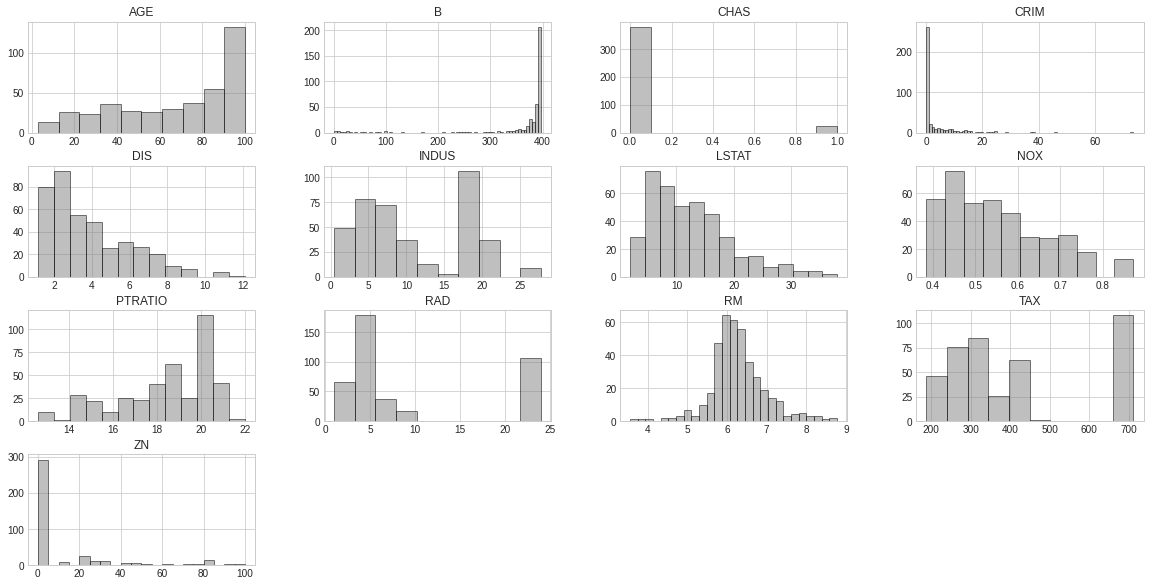

In [173]:
X_train.hist(figsize = (20,10), bins = 'auto', edgecolor = 'black', alpha = .5, color = 'grey');

In [0]:
models = [KNeighborsRegressor(), RandomForestRegressor(random_state = 1990, n_estimators= 25), SVR()]

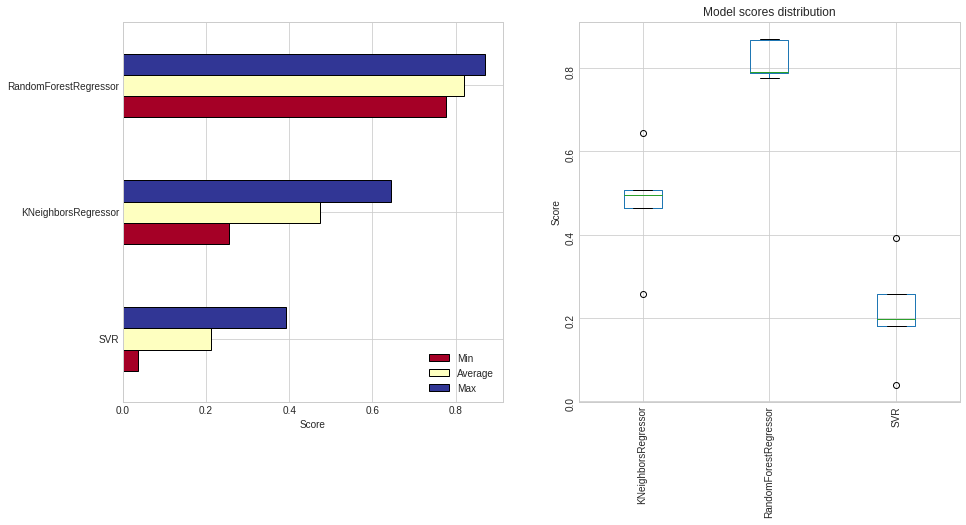

In [175]:
plot_cv_score(X_train, y_train, models)

In [0]:
pipe = Pipeline([('scaler', StandardScaler()), ('feat_reduction', PCA()), ('model', Lasso())])

In [0]:
param_grid = [{
'model':[KNeighborsRegressor( )],
'scaler':[StandardScaler(), RobustScaler()],
'feat_reduction':[FeatureAgglomeration()],
'feat_reduction__n_clusters':[2,4,6,8,10],
'model__n_neighbors':[1,3,5,7,15,25]

},
{
'model':[SVR()],
 'scaler':[StandardScaler(), RobustScaler()],
'feat_reduction':[FeatureAgglomeration()],
'feat_reduction__n_clusters':[2,4,6,8, 10],
'model__kernel':['linear', 'rbf']
}]

In [0]:
grid = RandomizedSearchCV(estimator = pipe, param_distributions= param_grid, n_jobs= -1, random_state= 1990).fit(X_train, y_train)

In [179]:
grid.best_score_

0.7356028146136308

In [0]:
models.append(grid.best_estimator_)

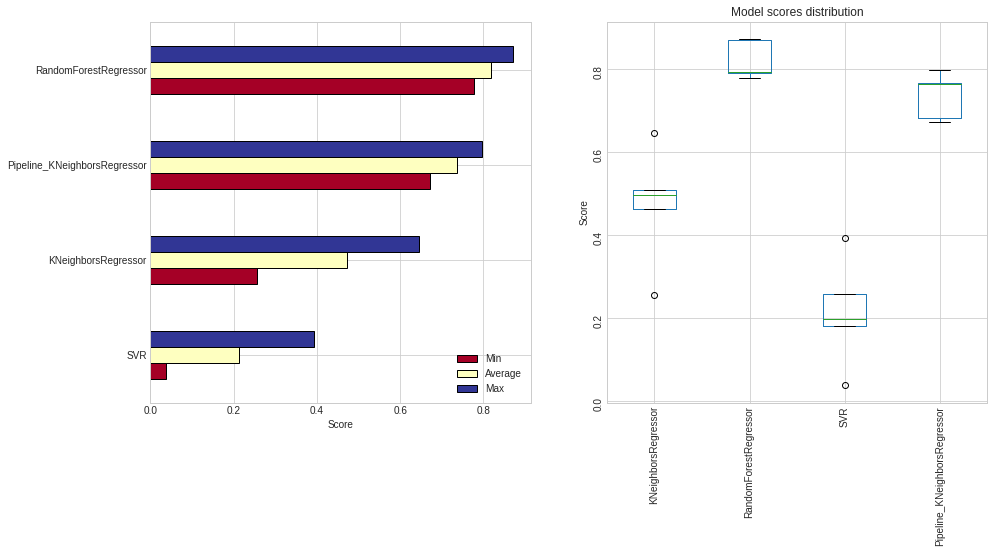

In [181]:
plot_cv_score(X_train, y_train, models)